## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw

import scipy.optimize as scopt

%matplotlib inline

In [2]:
PATH= '/data/eolson/MEOPAR/SS36runs/linkHC201812/'
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2018,12,31)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'grid_T':1}

df1=et.loadDFOCTD(datelims=(dt.datetime(2015,1,1),dt.datetime(2019,1,1)))
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,dtUTC
0,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,1.983099,29.849611,8.942753,2015-02-11 05:17:46
1,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,2.974641,29.852177,8.942511,2015-02-11 05:17:46
2,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,3.966178,29.869012,8.941135,2015-02-11 05:17:46
3,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,4.957711,29.915690,8.936661,2015-02-11 05:17:46
4,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,5.949239,29.913935,8.936489,2015-02-11 05:17:46


In [3]:
df2=df1.loc[(df1.Lat<48.6)&(df1.Lon<-124.5)]
df2.head()

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,dtUTC
1152,2015.0,7.0,31.0,20.696667,48.5695,-124.7425,3.966194,30.920361,12.458092,2015-07-31 20:41:48
1153,2015.0,7.0,31.0,20.696667,48.5695,-124.7425,4.957731,30.931273,12.414500,2015-07-31 20:41:48
1154,2015.0,7.0,31.0,20.696667,48.5695,-124.7425,5.949262,30.936659,12.415266,2015-07-31 20:41:48
1155,2015.0,7.0,31.0,20.696667,48.5695,-124.7425,6.940789,31.019113,12.203299,2015-07-31 20:41:48
1156,2015.0,7.0,31.0,20.696667,48.5695,-124.7425,7.932311,31.131612,11.925437,2015-07-31 20:41:48


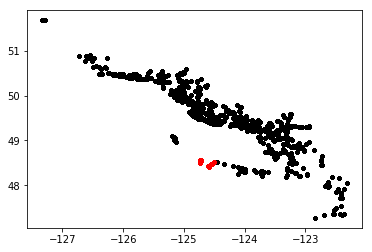

In [4]:
plt.plot(df1.Lon,df1.Lat,'k.')
plt.plot(df2.Lon,df2.Lat,'r.')

In [5]:
data=et.matchData(df2,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

progress: 0.0%
progress: 55.72893446277307%


In [6]:
data.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Z', 'SA', 'CT', 'dtUTC',
       'j', 'i', 'mod_votemper'],
      dtype='object')

In [7]:
data['LOmin']=np.zeros(np.shape(data['Lat']))

In [8]:
data['LOmax']=np.zeros(np.shape(data['Lat']))

In [9]:
zex=nc.Dataset('/data/eolson/results/MEOPAR/SS36runs/linkHC201812/05nov15/SalishSea_1d_20151105_20151105_ptrc_T.nc')
zex.variables.keys()

odict_keys(['nav_lat', 'nav_lon', 'bounds_lon', 'bounds_lat', 'area', 'deptht', 'deptht_bounds', 'nitrate', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'ammonium', 'silicon', 'diatoms', 'flagellates', 'ciliates', 'microzooplankton', 'dissolved_organic_nitrogen', 'particulate_organic_nitrogen', 'biogenic_silicon', 'Fraser_tracer', 'mesozooplankton'])

In [10]:
f=nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_y2015m06d05.nc')
print(f.variables.keys())
f.close()

odict_keys(['time_counter', 'deptht', 'yb', 'xbT', 'vosaline', 'votemper', 'NO3', 'Si', 'OXY', 'DIC', 'TA'])


In [11]:
#'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_y2016m09d26.nc'
for i,r in data.iterrows():
    stencil='/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{}.nc'
    try:
        file=glob.glob(stencil.format(r['dtUTC'].strftime('y%Ym%md%d')))[0]

    except:
        print('file does not exist:  '+stencil.format(r['dtUTC'].strftime('y%Ym%md%d')))
        raise
    k=et._getZInd_bin(r['Z'],zex)
    with nc.Dataset(file) as f:
        nmin=np.min(f.variables['votemper'][0,k,0,:])
        nmax=np.max(f.variables['votemper'][0,k,0,:])
    data.loc[i,['LOmin']]=nmin
    data.loc[i,['LOmax']]=nmax

In [12]:
data.head()

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,dtUTC,j,i,mod_votemper,LOmin,LOmax
0,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,0.991562,29.579209,10.562454,2015-04-02 15:23:46,413,7,10.996778,10.784300,11.400812
1,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,1.983119,29.578066,10.564277,2015-04-02 15:23:46,413,7,11.000047,10.801021,11.425672
2,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,2.974672,29.581444,10.560781,2015-04-02 15:23:46,413,7,11.003115,10.804991,11.424323
3,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,3.966220,29.587334,10.553512,2015-04-02 15:23:46,413,7,11.006428,10.791638,11.413043
4,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,4.957762,29.593827,10.544420,2015-04-02 15:23:46,413,7,11.013078,10.741391,11.410888


In [13]:
def outside(lo,hi,val):
    if val>hi:
        y=val-hi
    elif val<lo:
        y=val-lo
    else:
        y=0
    return y

In [14]:
data['outside']=[outside(lo,hi,val) for lo,hi,val in zip(data['LOmin'],data['LOmax'],data['mod_votemper'])]

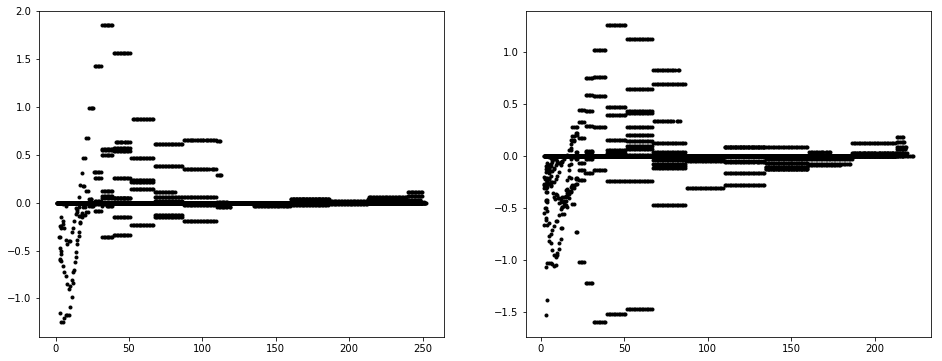

In [15]:
fig,ax=plt.subplots(1,2,figsize=(16,6))
d1=data.loc[data.Lon<-124.6]
d2=data.loc[data.Lon>=-124.6]
ax[0].plot(d1['Z'],d1['outside'],'k.')
ax[1].plot(d2['Z'],d2['outside'],'k.')
d3=data.loc[data['outside']==0]

# T data comparisons

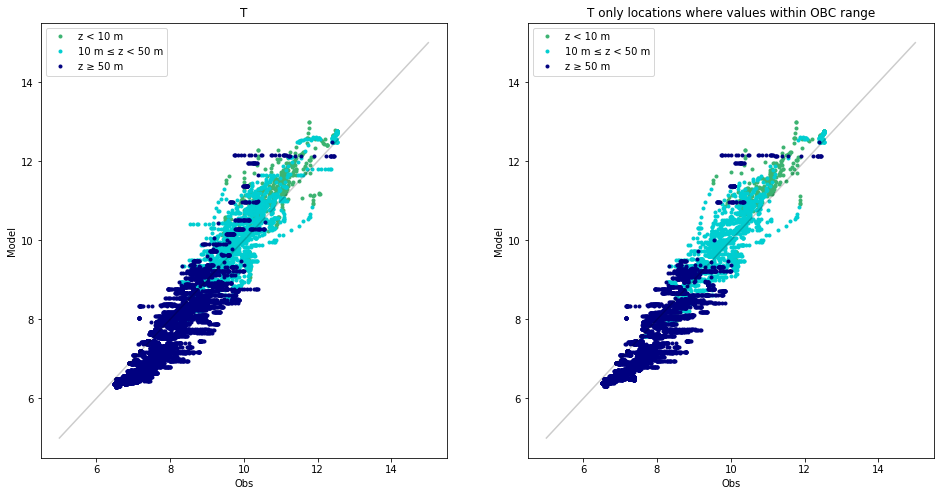

In [16]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'CT','mod_votemper','Z',(10,50),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('T')
ax[0].plot((5,15),(5,15),'k-',alpha=.2)

ps=et.varvarPlot(ax[1],d3,'CT','mod_votemper','Z',(10,50),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('T only locations where values within OBC range')
ax[1].plot((5,15),(5,15),'k-',alpha=.2)

By Year for all Depths


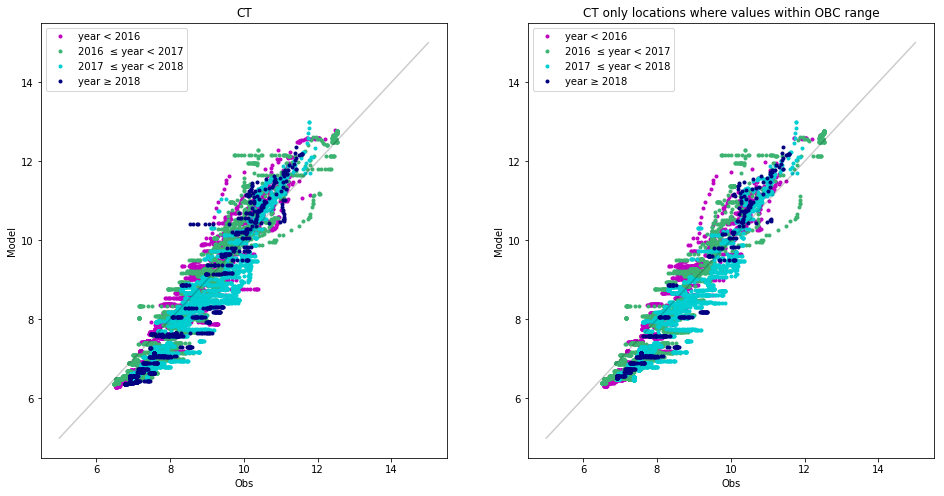

In [17]:
data2=data#.loc[data.Z>75]
fig, ax = plt.subplots(1,2,figsize = (16,8))
iax=ax[0]
ps=et.varvarPlot(iax,data2,'CT','mod_votemper','Year',(2016,2017,2018),'year','',('m','mediumseagreen','darkturquoise','navy'))
iax.legend(handles=ps)
iax.set_xlabel('Obs')
iax.set_ylabel('Model')
iax.set_title('CT')
iax.plot((5,15),(5,15),'k-',alpha=.2)

d32=d3#.loc[d3.Z>75]
iax=ax[1]
ps=et.varvarPlot(iax,d32,'CT','mod_votemper','Year',(2016,2017,2018),'year','',('m','mediumseagreen','darkturquoise','navy'))
iax.legend(handles=ps)
iax.set_xlabel('Obs')
iax.set_ylabel('Model')
iax.set_title('CT only locations where values within OBC range')
iax.plot((5,15),(5,15),'k-',alpha=.2)
print('By Year for all Depths')